In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
        UpSampling2D, Lambda, Activation, merge
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz

Using TensorFlow backend.


In [2]:
#Load dataset (ImageNet dataset)
#x_train = Low res = 72 x 72 x 3 (RGB)
#y_train = High res = 288 x 288 x 3 (RGB)

x_train = bcolz.open('data/x_train.bc')[:]
y_train = bcolz.open('data/y_train.bc')[:]
output_shape = y_train[0].shape
num_images = y_train.shape[0]

In [3]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, (size,size), strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(blockInput, num_filters=64):
    x = convolution_block(blockInput, num_filters, 3)
    x = convolution_block(x, num_filters, 3, activation=False)
    x = merge([x, blockInput], mode='sum')
    return x

def upsampling_block(x, filters, size):
    x = UpSampling2D()(x)
    x = Conv2D(filters, (size,size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_output(m, ln):
    name = 'block' + str(ln) + '_conv1'
    return m.get_layer(name).output

def mean_squared_error(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def content_fn(x):
    res = 0
    n=len(layer_weights)
    for i in range(n):
        res += mean_squared_error(x[i]-x[i+n]) * layer_weights[i]
    return res

In [4]:
'''NETWORK #1'''
inp=Input(x_train.shape[1:])
x=convolution_block(inp, 64, 9)
x=residual_block(x)
x=residual_block(x)
x=residual_block(x)
x=residual_block(x)
x=upsampling_block(x, 64, 3)
x=upsampling_block(x, 64, 3)
#n1_out=convolution_block(x, 3, 9)
x=Conv2D(3, (9,9), activation='tanh', padding='same')(x)
n1_out=Lambda(lambda x: (x+1)*127.5)(x) #scale output so we get 0 to 255

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [5]:
'''NETWORK #2 - VGG'''
#We want to use VGG so that we know the difference in activation between
#high-res image and output of the low-res image
#High-res -> VGG -> high-res activation
#Low-res -> trainableCNN -> VGG -> generated image activation

#Note that there are 2 inputs for VGG network:
#   1. Output of the low-res image from trainable network
#   2. High-res image

'''VGG input preprocessing as stated in the paper'''
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess_vgg = lambda x: (x - vgg_mean)[:, :, :, ::-1]

vgg_inp=Input(output_shape)
vgg= VGG16(include_top=False, input_tensor=Lambda(preprocess_vgg)(vgg_inp))

#Make sure vgg layers are not trainable
for layer in vgg.layers: 
    layer.trainable=False

In [6]:
#Define model that will grab the activations from first 3 conv layers
vgg_content = Model(vgg_inp, [get_output(vgg, o) for o in [1,2,3]])

#vgg1 = for the high res image
vgg1 = vgg_content(vgg_inp)

#vgg2 = for the generated image
vgg2 = vgg_content(n1_out)

In [7]:
#Define weights: how much each conv layer output to effect the model
layer_weights=[0.3, 0.65, 0.05]

In [8]:
#Define the model that actually minimizes the loss
model = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))

#We want the output of our model (loss) to be zeros
target = np.zeros((num_images, 1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
#DO NOT RUN THIS IF YOU WISH TO USE EXISTING MODEL
#Train model and load it
model.fit([x_train, y_train], target, batch_size=25, epochs=100)
trained_model = Model(inp, n1_out)

#Save weights
trained_model.save_weights('model1_100epochs.h5')

In [9]:
#Load a model (without training) if already exist
trained_model = Model(inp, n1_out)
trained_model.load_weights('model1_100epochs.h5')

## Now we can upscale our low res images with this model

In [10]:
#Let's predict randomly picked 5 images
predictions = trained_model.predict(np.expand_dims(x_train[7], axis=0))
predictions = np.concatenate((predictions,trained_model.predict(np.expand_dims(x_train[56], axis=0))))
predictions = np.concatenate((predictions,trained_model.predict(np.expand_dims(x_train[1470], axis=0))))
predictions = np.concatenate((predictions,trained_model.predict(np.expand_dims(x_train[4117], axis=0))))
predictions = np.concatenate((predictions,trained_model.predict(np.expand_dims(x_train[6700], axis=0))))

In [11]:
#Save predictions to working directory
imsave('results/7_after.jpg',predictions[0].astype('uint8'))
imsave('results/56_after.jpg',predictions[1].astype('uint8'))
imsave('results/1470_after.jpg',predictions[2].astype('uint8'))
imsave('results/4117_after.jpg',predictions[3].astype('uint8'))
imsave('results/6700_after.jpg',predictions[4].astype('uint8'))

In [12]:
#I've scaled the low res image using GIMP so we can compare
GIMP_7 = Image.open('results/7_GIMP_CUBIC.jpg')
GIMP_56 = Image.open('results/56_GIMP_CUBIC.jpg')
GIMP_1470 = Image.open('results/1470_GIMP_CUBIC.jpg')
GIMP_4117 = Image.open('results/4117_GIMP_CUBIC.jpg')
GIMP_6700 = Image.open('results/6700_GIMP_CUBIC.jpg')

## Let's see the comparison

Original low resolution images


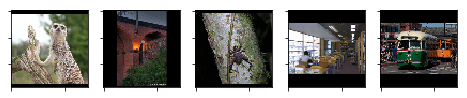

In [13]:
l = [7,56,1470,4117,6700]
gimps = [GIMP_7,GIMP_56,GIMP_1470,GIMP_4117,GIMP_6700]

print("Original low resolution images")
#Original low resolution images
fig,axes = plt.subplots(nrows=1, ncols=5, figsize=(8,8))
for i in range(5):
    axes[i].imshow(Image.fromarray(x_train[l[i]]))
    axes[i].set_yticklabels([])
    axes[i].set_xticklabels([])

Upscale using GIMP cubic transformation vs super resolution


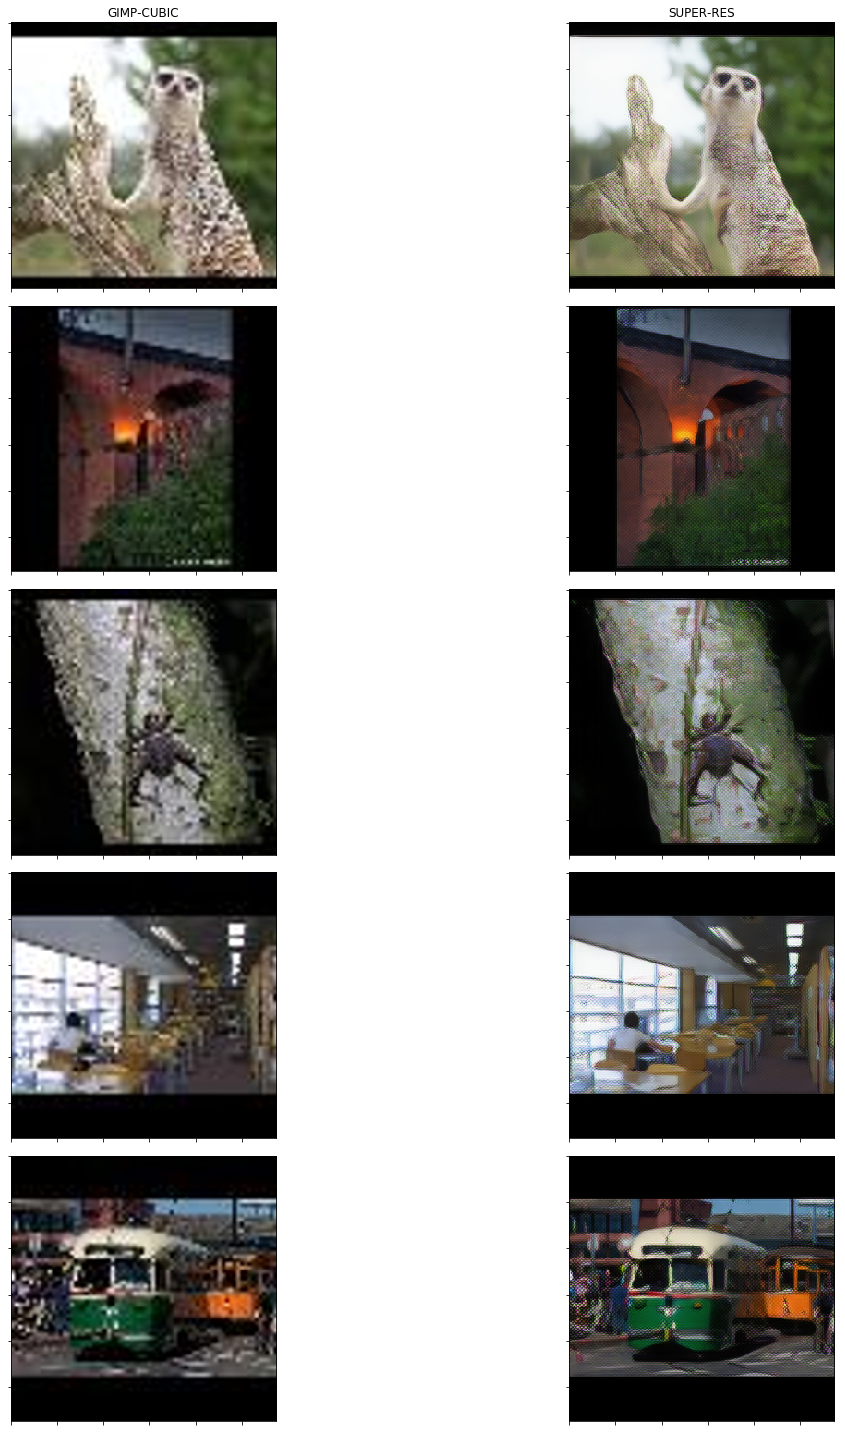

In [14]:
print("Upscale using GIMP cubic transformation vs super resolution")

columns = ['{}'.format(col) for col in ['GIMP-CUBIC', 'SUPER-RES']]

fig,axis = plt.subplots(nrows=5, ncols=2, figsize=(20,20))

for ax,col in zip(axis[0], columns):
    ax.set_title(col)

for i in range(5):
    axis[i,0].imshow(gimps[i])
    axis[i,1].imshow(Image.fromarray(predictions[i].astype('uint8')))
    axis[i,0].set_yticklabels([])
    axis[i,0].set_xticklabels([])
    axis[i,1].set_yticklabels([])
    axis[i,1].set_xticklabels([])

plt.tight_layout()
plt.show()